In [2]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

In [5]:
from proj1_helpers import *
DATA_TRAIN_PATH = '../data/train.csv' # TODO: download train data and supply path here 
y, tX, ids = load_csv_data(DATA_TRAIN_PATH, sub_sample=True)

### IMPLEMENTATIONS (will move to seperate file later)

### Utility functions

In [6]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def compute_accuracy(pred, actual):
    return np.sum(pred == actual) / len(actual)

def predict_labels(y_pred, cutoff=0):
    y_pred[np.where(y_pred <= cutoff)] = -1
    y_pred[np.where(y_pred > cutoff)] = 1
    return y_pred

def predict_labels_01(y_pred, cutoff=0.5):
    y_pred[np.where(y_pred <= cutoff)] = 0
    y_pred[np.where(y_pred > cutoff)] = 1
    return y_pred

def build_k_indices(num_row, k_fold):
    """build k indices for k-fold."""
    interval = int(num_row / k_fold)
    indices = np.random.permutation(num_row)
    k_indices = [indices[k * interval : (k + 1) * interval]
                 for k in range(k_fold)]
    return np.array(k_indices)

def remove_single_col(X, X_train):
    N, M = X.shape
    to_del = []
    for i in range(M):
        col = X[:, i]
        if ((col - col.mean()).mean()) == 0: 
            to_del.append(i)
    return np.delete(X, to_del, 1), np.delete(X_train, to_del, 1)

def batch_iter(y, tx, batch_size, num_batches=1, shuffle=True):
    """
    Generate a minibatch iterator for a dataset.
    Takes as input two iterables (here the output desired values 'y' and the input data 'tx')
    Outputs an iterator which gives mini-batches of `batch_size` matching elements from `y` and `tx`.
    Data can be randomly shuffled to avoid ordering in the original data messing with the randomness of the minibatches.
    Example of use :
    for minibatch_y, minibatch_tx in batch_iter(y, tx, 32):
        <DO-SOMETHING>
    """
    data_size = len(y)

    if shuffle:
        shuffle_indices = np.random.permutation(np.arange(data_size))
        shuffled_y = y[shuffle_indices]
        shuffled_tx = tx[shuffle_indices]
    else:
        shuffled_y = y
        shuffled_tx = tx
    for batch_num in range(num_batches):
        start_index = batch_num * batch_size
        end_index = min((batch_num + 1) * batch_size, data_size)
        if start_index != end_index:
            yield shuffled_y[start_index:end_index], shuffled_tx[start_index:end_index]

### Graph plot functions

In [7]:
def plot_bar_graph(headers, x1_data, x2_data, x1_label, x2_label, y_label, title):
    x = np.arange(len(headers))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots()

    ax.bar(x - width/2, x1_data, width, label=x1_label)
    ax.bar(x + width/2, x2_data, width, label=x2_label)

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel(y_label)
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(headers)
    ax.legend()

    fig.tight_layout()

    plt.show()
    
def plot_line_graph(title, y, t1, t2, t1_label, t2_label, y_label, x_label):
    plt.plot(y, t1, 'b-', label=t1_label)
    plt.plot(y, t2, 'r-', label=t2_label)
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    plt.legend(loc='upper left')
    plt.title(title)
    plt.show()

### Impute missing data with most frequent value in the column

In [8]:
from collections import Counter

class Imputer:
    def __init__(self, missing_values, strategy):
        self._mv = missing_values
        
        err_msg = "strategy must be 'mean', 'median' or 'most frequent', but got: {}".format(strategy)
        assert strategy in ["mean", "median", "most frequent"], err_msg
        
        self._strategy = strategy
        
    def _mode(self, X):
        N, M = X.shape
        for i in range(M):
            col = list(filter(lambda x : x != self._mv, X[:, i]))
            mode = [self._mv]
            
            if len(col) > 0:
                counter = Counter(col)
                max_count = max(counter.values())
                mode = [k for k,v in counter.items() if v == max_count]
            
            self.cache.append(mode[0])
        
    def _mean(self, X):
        N, M = X.shape
        for i in range(M):
            miss_index = X[:, i] == -999
            mu = np.mean(X[~miss_index, i])
            self.cache.append(mu)
        
    def _median(self, X):
        N, M = X.shape
        for i in range(M):
            miss_index = X[:, i] == -999
            median = np.median(X[~miss_index, i])
            self.cache.append(median)  
            
    def fit(self, X):
        self.cache = []
        if self._strategy == "most frequent": self._mode(X)
        elif self._strategy == "mean": self._mean(X)
        elif self._strategy == "median": self._median(X)
        
    def transform(self, X):
        N, M = X.shape
        nX = np.array(X, copy=True)
        for i in range(M):
            c = nX[:, i]
            c[c == self._mv] = self.cache[i]
        
        del_c = []
        for i in range(M):
            c = nX[:, i]
            if c[c == self._mv].size > 0:
                del_c.append(i)
                
        nX = np.delete(nX, del_c, 1)
        return nX
        
    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

### Other options to handle missing data:

#### Remove the feature with more than half missing value

In [9]:
def remove_dirty_col(X):
    ''' Remove the column with more than half of missing values '''
    N, M = X.shape
    res = []
    nX = np.array(X, copy=True)
    
    for i in range(M):
        miss = np.count_nonzero(nX[:, i] >= -990)
        if (miss >= N/2):
            res = nX[:, i]
        else:
            res = np.c_[res, nX[:, i]]
    
    return res

#### Remove outliers by standard deviation bounds

In [10]:
def handle_outliers(X):
    ''' Remove outliers by standard deviation bound '''
    N, M = X.shape
    nX = np.array(X, copy=True)
    
    for i in range(M):
        curr_col = nX[:, i]
        
        std = np.std(nX[:, i])
        mean = np.mean(nX[:, i])
        lower = mean - 2 * std
        upper = mean + 2 * std
        
        lower_outlier_index = nX[:, i] < lower
        upper_outlier_index = nX[:, i] > upper
        
        curr_col[lower_outlier_index] = lower
        curr_col[upper_outlier_index] = upper
        
    return nX

#### Replace the missing value with mean of the valid data

In [11]:
def replace_miss_with_mean(X):
    ''' Replace the missing value with mean of the column '''
    N, M = X.shape
    nX = np.array(X, copy=True)
    
    for i in range(M):
        miss_index = nX[:, i] >= -990
        if (np.sum(miss_index) > 0):
            nX[miss_index] = np.mean(nX[~miss_index, i])
    
    return nX

#### Replace the missing value with median of the valid data

In [12]:
def replace_miss_with_median(X):
    ''' Replace the missing value with median of the column '''
    N, M = X.shape
    nx = np.array(X, copy=True)
    
    for i in range(M):
        miss_index = nX[:, i] >= -990
        if (np.sum(miss_index) > 0):
            nX[miss_index] = np.median(nX[~miss_index, i])
            
    return nX

### Data normalisation

In [13]:
class Scaler:
    def fit(self, X):
        self.mu = np.mean(X, axis=0)
        self.std = np.std(X, axis=0)
        
    def transform(self, X):
        return (X - self.mu) / self.std
    
    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

### Regression technique implementations

In [26]:
class LogisticRegression:
    def __init__(self, lambda_=0, fit_intercept=True):
        self.theta = None
        self.lambda_ = lambda_
        self.fit_intercept = fit_intercept
    
    def fit(self, X, y, step=0.05, threshold=1e-8, max_iter=10000000007, batch_size=-1):
        if self.fit_intercept:
            X = np.c_[np.ones(X.shape[0]), X]
        
        loss_prev = np.inf
        self.theta = np.zeros(X.shape[1])
        
        it = None
        if batch_size != -1:
            it = batch_iter(y, X, batch_size, num_batches=max_iter)
        
        for _ in range(max_iter):
            y_pred = sigmoid(np.dot(X, self.theta))
            loss = self._NLL(X, y, y_pred)
            if loss_prev - loss < threshold:
                return
            loss_prev = loss
            
            if batch_size != -1:
                y_batch, X_batch = next(it)
                y_pred_batch = sigmoid(np.dot(X_batch, self.theta))
                self.theta -= step*self._NLL_Gradient(X_batch, y_batch, y_pred_batch)
                continue
            
            self.theta -= step*self._NLL_Gradient(X, y, y_pred)
            
    def _NLL(self, X, y, y_pred):
        nll = -np.log(y_pred[y == 1]).sum() - np.log(1 - y_pred[y == 0]).sum()
        penalty = 0.5 * self.lambda_ * np.linalg.norm(self.theta, 2) ** 2
        return (penalty + nll) / X.shape[0]
    
    def _NLL_Gradient(self, X, y, y_pred):
        d_penalty = self.lambda_ * self.theta
        return -(np.dot(y - y_pred, X) + d_penalty) / X.shape[0]    
    
    def predict(self, X):
        if self.fit_intercept:
            X = np.c_[np.ones(X.shape[0]), X]
        return sigmoid(np.dot(X, self.theta))

In [15]:
class LeastSquares:
    def __init__(self, fit_intercept=True):
        self.theta = None
        self.fit_intercept = fit_intercept
    
    def fit(self, X, y):
        if self.fit_intercept:
            X = np.c_[np.ones(X.shape[0]), X]
        self.theta = np.linalg.solve(X.T.dot(X), X.T.dot(y))
        
    def predict(self, X):
        if self.fit_intercept:
            X = np.c_[np.ones(X.shape[0]), X]
        return np.dot(X, self.theta)

In [16]:
class RidgeRegressionLS:
    def __init__(self, lambda_=0.1, fit_intercept=True):
        self.theta = None
        self.lambda_ = lambda_
        self.fit_intercept = fit_intercept
    
    def fit(self, X, y):
        if self.fit_intercept:
            X = np.c_[np.ones(X.shape[0]), X]
        N, M = X.shape
        A = X.T.dot(X) + lambda_*2*N*np.eye(M)
        b = X.T.dot(y)
        self.theta = np.linalg.solve(A, b)
        
    def predict(self, X):
        if self.fit_intercept:
            X = np.c_[np.ones(X.shape[0]), X]
        return np.dot(X, self.theta)

In [17]:
class LinearRegressionGD:
    def __init__(self, lambda_=0.1, fit_intercept=True):
        self.theta = None
        self.lambda_ = lambda_
        self.fit_intercept = fit_intercept
    
    def fit(self, X, y, step=0.5, threshold=1e-8, max_iter=100, batch_size=-1):
        if self.fit_intercept:
            X = np.c_[np.ones(X.shape[0]), X]
        loss_prev = np.inf
        self.theta = np.zeros(X.shape[1])
        
        it = None
        if batch_size != -1:
            it = batch_iter(y, X, batch_size, num_batches=max_iter)
        
        for _ in range(max_iter):            
            y_pred = np.dot(X, self.theta)
            loss = self._MSE(y, y_pred)
            if loss_prev - loss < threshold:
                return
            loss_prev = loss
            
            if batch_size != -1:
                y_batch, X_batch = next(it)
                y_pred_batch = np.dot(X_batch, self.theta)
                self.theta -= step*self._MSE_Gradient(X_batch, y_batch, y_pred_batch)
                continue
            
            self.theta -= step*self._MSE_Gradient(X, y, y_pred)

    def _MSE(self, y, y_pred):
        return np.square(y - y_pred).mean() * (1 / 2)
    
    def _MSE_Gradient(self, X, y, y_pred):
        N, M = X.shape
        return (X.T.dot(y - y_pred)) * (-1 / N)
        
    def predict(self, X):
        if self.fit_intercept:
            X = np.c_[np.ones(X.shape[0]), X]
        return np.dot(X, self.theta) 

### Cross validation function

In [27]:
def cross_validate(model, X, y, k_fold=10, seed=1, cutoff=0):
    np.random.seed(seed) 
    k_indices = build_k_indices(y.shape[0], k_fold)
    test_acc = []
    train_acc = []
    
    def run_cv(k):
        k_test = k_indices[k]
        
        mask = np.ones(len(k_indices), dtype=bool)
        mask[[k]] = False
        k_train = k_indices[mask].ravel()
        
        X_train, y_train = X[k_train], y[k_train]
        X_test, y_test = X[k_test], y[k_test]
        print(y_test==1)
        
        model.fit(X_train, y_train)
  
        y_pred = predict_labels(model.predict(X_test), cutoff=cutoff)        
        test_acc.append(compute_accuracy(y_pred, y_test))
        
        y_pred_train = predict_labels(model.predict(X_train))
        train_acc.append(compute_accuracy(y_pred_train, y_train))
        
    for k in range(k_fold):
        run_cv(k)
    
    return np.array(train_acc), np.array(test_acc)

## INSERT DATA EXPLORATION STUFF HERE

## Initial Run

Lets just stuff all the data into all our models and compare the average train/test loss using a 10-fold CV with default values for hyperparameters

In [28]:
seed = 60

[False False False False False  True False False False  True False False
 False  True False False False False  True False False  True False False
 False False False False  True False False False False  True False False
 False False False  True  True False False  True  True False False  True
  True False False  True  True  True  True False False False  True False
 False False False False False False  True False False False  True False
 False False False  True False  True False False False False  True False
 False  True False False  True False  True False False False False False
 False False  True False False False  True False  True  True False  True
 False  True  True False False False False False  True False False  True
 False False  True False False  True False False False False False False
 False  True False  True False  True False False  True False False False
 False False False False False False  True  True  True False  True  True
 False False  True False  True False False False Fa

/Users/rahul/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in log


[False  True False False False False False False False False False False
  True False False False  True False False  True False  True False False
 False False False False  True False False  True False  True False False
 False False  True  True False False False False  True False  True False
  True False False False False False False False  True False  True  True
  True False  True  True False False False False  True False False False
 False False False  True False False False False False  True False False
 False False False False  True False False  True  True  True  True False
  True False False False False False  True  True False False False False
 False False False False False False  True  True  True False False False
  True  True False  True False False  True False False False False  True
 False  True  True  True  True False  True  True False False False False
  True False False False False False  True False  True False  True  True
 False False  True False False False  True False Fa

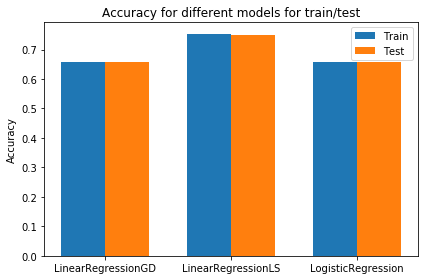

In [29]:
headers = ["LinearRegressionGD", "LinearRegressionLS", "LogisticRegression"]
models = [LinearRegressionGD(), LeastSquares(), LogisticRegression()]  
cutoffs = [0, 0, 0.5]

train_acc_list = []
test_acc_list = []

for i, model in enumerate(models):
    train_acc, test_acc = cross_validate(model, tX, y, seed=seed, cutoff=cutoffs[i])
    print("{0}: Train Accuracy:{1:.3f} (+/- {2:.6f}), Test Accuracy:{3:.3f} (+/- {4:.6f})".format(
        headers[i], train_acc.mean(), train_acc.std() * 2, test_acc.mean(), test_acc.std() * 2))
    
    train_acc_list.append(train_acc.mean())
    test_acc_list.append(test_acc.mean())
    
plot_bar_graph(headers, train_acc_list, test_acc_list, "Train", "Test", "Accuracy", 
               "Accuracy for different models for train/test")

### Observations

The gradient descent method is not doing so well especially for logistic regression. Some reasons for this are as follows:
- features are not normalized (log regression does poorly as a result - see RunTimeWarning above) + undefined values (-999)
- Also there is no regularization (although looking at train vs test accuracies above, there is no overfitting yet)

#### Current Winner : Linear Regression with Normal Equation

## Feature Cleaning

- Let us clean the features: replace -999 and normalize the values
- Add a small factor of regularization to regression (for some noise)

In [126]:
def preprocess(X, X_test, strategy="most frequent"):
    
    # Impute -999 with most frequent value
    imputer = Imputer(-999, strategy)
    X = imputer.fit_transform(X)
    X_test = imputer.transform(X_test)
    
    # print(X.shape)
    
    # Normalize values
    scaler = Scaler()
    X = scaler.fit_transform(X)
    X_test = scaler.transform(X_test)
    
    return X, X_test

In [19]:
def cross_validate_with_preprocess(model, X, y, k_fold=10, seed=1, cutoff=0):
    np.random.seed(seed) 
    k_indices = build_k_indices(y.shape[0], k_fold)
    test_acc = []
    train_acc = []
    
    def run_cv(k):
        k_test = k_indices[k]
        
        mask = np.ones(len(k_indices), dtype=bool)
        mask[[k]] = False
        k_train = k_indices[mask].ravel()
        
        X_train, y_train = X[k_train], y[k_train]
        X_test, y_test = X[k_test], y[k_test]
        
        X_train, X_test = preprocess(X_train, X_test)
        model.fit(X_train, y_train)
  
        y_pred = predict_labels(model.predict(X_test), cutoff=cutoff)        
        test_acc.append(compute_accuracy(y_pred, y_test))
        
        y_pred_train = predict_labels(model.predict(X_train), cutoff=cutoff)
        train_acc.append(compute_accuracy(y_pred_train, y_train))
        
    for k in range(k_fold):
        run_cv(k)
    
    return np.array(train_acc), np.array(test_acc)

In [1]:
headers = ["LinearRegressionGD", "LinearRegressionLS", "LogisticRegression"]
models = [LinearRegressionGD(), LeastSquares(), LogisticRegression()]  
cutoffs = [0.9, 0, 0.6]

train_acc_list = []
test_acc_list = []

for i, model in enumerate(models):
    train_acc, test_acc = cross_validate_with_preprocess(model, tX, y, seed=seed, cutoff=cutoffs[i])
    print("{0}: Train Accuracy:{1:.3f} (+/- {2:.6f}), Test Accuracy:{3:.3f} (+/- {4:.6f})".format(
        headers[i], train_acc.mean(), train_acc.std() * 2, test_acc.mean(), test_acc.std() * 2))
    
    train_acc_list.append(train_acc.mean())
    test_acc_list.append(test_acc.mean())
    
plot_bar_graph(headers, train_acc_list, test_acc_list, "Train", "Test", "Accuracy", 
               "Accuracy for different models for train/test")

NameError: name 'LinearRegressionGD' is not defined

Good news, there is no more Runtime Warning for logistic regression! The models which use gradient descent have now improved after cleaning/normalizing the features. There is not much difference for the Linear Regression with normal equation.


#### Let us see if adding a touch of noise will help us here - L2 Regularization

In [21]:
lambda_ = 0.0001

RidgeRegressionGD: Train Accuracy:0.703 (+/- 0.002890), Test Accuracy:0.704 (+/- 0.026521)
RidgeRegressionLS: Train Accuracy:0.754 (+/- 0.005348), Test Accuracy:0.752 (+/- 0.036330)
LogisticRegression: Train Accuracy:0.703 (+/- 0.002953), Test Accuracy:0.702 (+/- 0.024945)


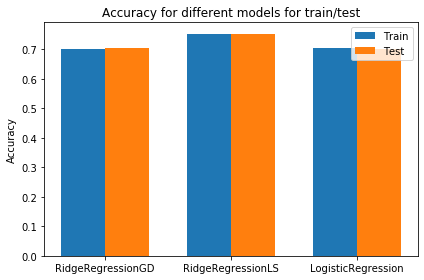

In [22]:
headers = ["RidgeRegressionGD", "RidgeRegressionLS", "LogisticRegression"]
models = [LinearRegressionGD(lambda_=lambda_), RidgeRegressionLS(lambda_=lambda_), 
          LogisticRegression(lambda_=lambda_)]  
cutoffs = [0.9, 0, 0.6]

train_acc_list = []
test_acc_list = []

for i, model in enumerate(models):
    train_acc, test_acc = cross_validate_with_preprocess(model, tX, y, seed=seed, cutoff=cutoffs[i])
    print("{0}: Train Accuracy:{1:.3f} (+/- {2:.6f}), Test Accuracy:{3:.3f} (+/- {4:.6f})".format(
        headers[i], train_acc.mean(), train_acc.std() * 2, test_acc.mean(), test_acc.std() * 2))
    
    train_acc_list.append(train_acc.mean())
    test_acc_list.append(test_acc.mean())
    
plot_bar_graph(headers, train_acc_list, test_acc_list, "Train", "Test", "Accuracy", 
               "Accuracy for different models for train/test")

### Observations

Unsurprisingly, the models are not really affected by regularization. This is a good indication that our model may be too simple. It is a good idea to engineer some features and make the model more complex. Once it starts to overfit, we could then increase the regularization constant (lambda_)


#### Current Winner : Ridge Regression with Normal Equation

## Feature Engineering

- Let us extend the features: add a polynomial basis up to a certain degree

In [23]:
def build_poly(X, degree):
    ''' Polynomial basis functions from input data x '''
    N, M = X.shape
    for d in range(2, degree+1):
        for i in range(M):
            col = X[:, i]
            X = np.c_[X, np.power(col, d)]
    return X

In [220]:
def cross_validate_with_preprocess_poly(model, X, y, degree, k_fold=10, seed=1, cutoff=0, strategy="most frequent"):
    np.random.seed(seed) 
    k_indices = build_k_indices(y.shape[0], k_fold)
    test_acc = []
    train_acc = []
    
    def run_cv(k):
        k_test = k_indices[k]
        
        mask = np.ones(len(k_indices), dtype=bool)
        mask[[k]] = False
        k_train = k_indices[mask].ravel()
        
        X_train, y_train = X[k_train], y[k_train]
        X_test, y_test = X[k_test], y[k_test]
                
        X_train, X_test = preprocess(X_train, X_test, degree, strategy)
        
        model.fit(X_train, y_train)
  
        y_pred = predict_labels(model.predict(X_test), cutoff=cutoff)        
        test_acc.append(compute_accuracy(y_pred, y_test))
        
        y_pred_train = predict_labels(model.predict(X_train), cutoff=cutoff)
        train_acc.append(compute_accuracy(y_pred_train, y_train))
        
    for k in range(k_fold):
        run_cv(k)
    
    return np.array(train_acc), np.array(test_acc)

In [106]:
lambda_ = 0.00000002
degree = 8

In [194]:
headers = ["RidgeRegressionGD", "RidgeRegressionLS", "LogisticRegression"]
models = [LinearRegressionGD(lambda_=lambda_), RidgeRegressionLS(lambda_=lambda_), 
          LogisticRegression(lambda_=lambda_)]  
cutoffs = [0, 0, 0.5]

train_acc_list = []
test_acc_list = []

for i, model in enumerate(models):
    train_acc, test_acc = cross_validate_with_preprocess_poly(model, tX, y, degree=degree,
                                                              seed=seed, cutoff=cutoffs[i])
    print("{0}: Train Accuracy:{1:.3f} (+/- {2:.6f}), Test Accuracy:{3:.3f} (+/- {4:.6f})".format(
        headers[i], train_acc.mean(), train_acc.std() * 2, test_acc.mean(), test_acc.std() * 2))
    
    train_acc_list.append(train_acc.mean())
    test_acc_list.append(test_acc.mean())
    
plot_bar_graph(headers, train_acc_list, test_acc_list, "Train", "Test", "Accuracy", 
               "Accuracy for different models for train/test")

RidgeRegressionGD: Train Accuracy:0.659 (+/- 0.002273), Test Accuracy:0.659 (+/- 0.006621)
RidgeRegressionLS: Train Accuracy:0.790 (+/- 0.000430), Test Accuracy:0.789 (+/- 0.003034)


KeyboardInterrupt: 

### Observations

Feature engineering definitely helps one of our models! Our best accuract now is around 0.77 with Ridge Regression with normal equation. Note: I used degree 10 for this

However, the other models that use Gradient Descent fare worse! We have to look into this and improve it


#### Current Winner : Ridge Regression with Normal Equation

## Improve Logistic Regression

It seems odd that logistic regression is not performing well for a classfication problem! We realised this is because the y labels are [-1,1] when the sigmoid function works over [0, 1]. Lets try change that and inmprove logistic regression!

In [252]:
log_y = np.array(y, copy=True)
log_y[log_y==-1] = 0

In [241]:
def cross_validate_logreg(model, X, y, degree, k_fold=10, seed=1):
    np.random.seed(seed) 
    k_indices = build_k_indices(y.shape[0], k_fold)
    test_acc = []
    train_acc = []
    
    def run_cv(k):
        k_test = k_indices[k]
        
        mask = np.ones(len(k_indices), dtype=bool)
        mask[[k]] = False
        k_train = k_indices[mask].ravel()
        
        X_train, y_train = X[k_train], y[k_train]
        X_test, y_test = X[k_test], y[k_test]
                
        X_train, X_test = preprocess(X_train, X_test, degree)
        
        model.fit(X_train, y_train, batch_size=1000)
  
        y_pred = predict_labels_01(model.predict(X_test))        
        test_acc.append(compute_accuracy(y_pred, y_test))
        
        y_pred_train = predict_labels_01(model.predict(X_train))
        train_acc.append(compute_accuracy(y_pred_train, y_train))
        
        print("CV: Train Accuracy:{0:.3f}, Test Accuracy:{1:.3f}".format(
            train_acc[-1], test_acc[-1]))
        
    for k in range(k_fold):
        run_cv(k)
    
    return np.array(train_acc), np.array(test_acc)

In [201]:
lambda_ = 0.0000002
degree = 1

In [231]:
model = LogisticRegression(lambda_=lambda_)
train_acc, test_acc = cross_validate_logreg(model, tX, log_y, degree=degree, seed=seed)
print("Train Accuracy:{0:.3f} (+/- {1:.6f}), Test Accuracy:{2:.3f} (+/- {3:.6f})".format(
    train_acc.mean(), train_acc.std() * 2, test_acc.mean(), test_acc.std() * 2))

KeyboardInterrupt: 

### Observations

There we go! The logistic regression model now produces a 0.80 accuracy which is a much more reliable prediction!

## Feature Engineering

- Let us do a log transformation of some of the variables

In [180]:
# Create inverse log values of features which is positive in value.
def inverse_log_cols(X, X_test):
    inv_log_cols = (0,1,2,3,4,5,7,8,9,10,12,13,16,19,21,23,26)
    X_inv_log_cols = np.log(1 / (1 + X[:, inv_log_cols]))
    X = np.hstack((X, X_inv_log_cols))
    X_test_inv_log_cols = np.log(1 / (1 + X_test[:, inv_log_cols]))
    X_test = np.hstack((X_test, X_test_inv_log_cols))
    return X, X_test

In [247]:
def preprocess(X, X_test, degree, strategy="most frequent"):
    
    # Impute -999 with most frequent value
    imputer = Imputer(-999, strategy)
    X = imputer.fit_transform(X)
    X_test = imputer.transform(X_test)
    
    # Log transformation
    X, X_test = inverse_log_cols(X, X_test)
    
    # extend matrix
    X = build_poly(X, degree)
    X_test = build_poly(X_test, degree)
    
    # Normalize values
    scaler = Scaler()
    X = scaler.fit_transform(X)
    X_test = scaler.transform(X_test)
    
    return X, X_test

## Ensemble Technique

A good strategy to tackle classification problems is to use an ensemble - you use different models and combine their results (either through voting/average). This is normally done using SVM/Random Forest/XGBoost etc. (models which are pretty different from each other). This helps to add some noise and improve accuracy of results.


In this case, we don't quite have other models other than Ridge Regression and Logisitc Regression. However, it is still worth a shot! We could run both models and take as 1s those which both models predict as 1s! 

## Strategy Outline

Now that we have done Data Exploration and Experimentation with various techniques, we can come up with a few strategies to tackle this problem.

### 1: Ridge Regression, High Degree, Low Lambda_

Ridge regression has a pretty good performane for this model after some preprocessing of the feature set. For this to work out we must normalize, do a polynomial expansion (with pretty high degree > 5) and a low lambda_ value. Ridge Regression also does well with the [-1,1] label set. We can optimize the hyperparameters further to get the best value.


### 2. Logistic Regression

This is after all a classification problem which is best tackled with logistic regression! For this to work, we must use [0,1] labels, a degree of around 5 and a high enough lambda_ to prevent overfitting. Similar to above, we must tweak hyperparamters



### 3. Ensemble Technique

As experimented above, we could combine the results of logistic regression and ridge regression to get a more accurate result.

## Hyperparameter Tuning

- Now that we have a good choice of what strategies to go with and a reasonable feature set-up, we need to tune our hyperparemeters (lambda_ / step_size / degree) for the various strategies to get the best results

### Strategy 1 : Ridge Regression

Let's tweak lambda_ and degree for ridge regression

0.7762346666666666 / 0.7757799999999999
0.7999826666666666 / 0.799576
0.8080986666666667 / 0.807536
0.8142346666666667 / 0.81364
0.8175866666666667 / 0.817032
0.8186813333333334 / 0.817852
0.8194693333333334 / 0.8186840000000001
0.820088 / 0.8192280000000001
0.8205253333333333 / 0.8198240000000001
0.820712 / 0.8199719999999999
0.8209253333333333 / 0.819996
0.8210573333333333 / 0.82026
0.8212306666666667 / 0.820452
0.8212946666666667 / 0.8205279999999999
0.8214986666666667 / 0.8205880000000001


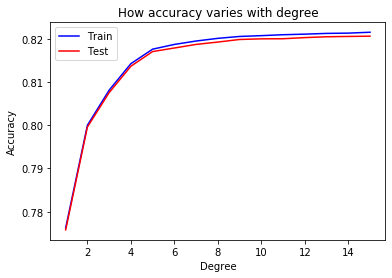

In [222]:
lambda_ = 1e-10
degrees = [i for i in range(1, 16)]

model = RidgeRegressionLS(lambda_=lambda_)

train_acc_set = []
test_acc_set = []

for degree in degrees:
    train_acc, test_acc = cross_validate_with_preprocess_poly(model, tX, y, k_fold=4, degree=degree, seed=seed)
    train_acc_set.append(train_acc.mean())
    test_acc_set.append(test_acc.mean())
    print("{0} / {1}".format(train_acc_set[-1], test_acc_set[-1]))
    
plot_line_graph("How accuracy varies with degree", 
                degrees, train_acc_set, test_acc_set, "Train", "Test", "Accuracy", "Degree")

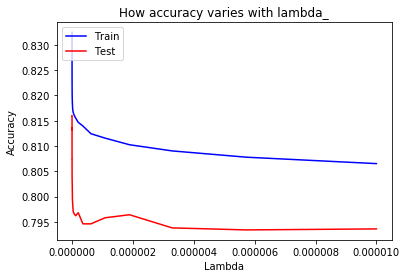

In [70]:
degree = 10
lambda_set = np.logspace(-12, -5, 30)

train_acc_set = []
test_acc_set = []

for lambda_ in lambda_set:
    model = RidgeRegressionLS(lambda_=lambda_)
    train_acc, test_acc = cross_validate_with_preprocess_poly(model, tX, y, degree=degree, seed=seed)
    train_acc_set.append(train_acc.mean())
    test_acc_set.append(test_acc.mean())

plot_line_graph("How accuracy varies with lambda_", 
                lambda_set, train_acc_set, test_acc_set, "Train", "Test", "Accuracy", "Lambda")

lambda_ = 1.00000000e-10 and degree = 10 looks like it would give a good fit for Ridge Regression using normal equation

0.8027573333333333 / 0.802304
0.8027573333333333 / 0.802304
0.8027573333333333 / 0.802304


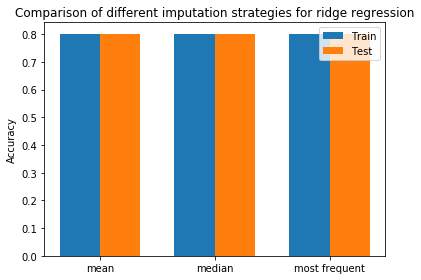

In [141]:
lambda_ = 1e-10
degree = 13
strategies = ["mean", "median", "most frequent"]

model = RidgeRegressionLS(lambda_=lambda_)

train_acc_set = []
test_acc_set = []

for strategy in strategies:
    train_acc, test_acc = cross_validate_with_preprocess_poly(model, tX, y, degree=degree, seed=seed, strategy=strategy)
    train_acc_set.append(train_acc.mean())
    test_acc_set.append(test_acc.mean())
    print("{0} / {1}".format(train_acc_set[-1], test_acc_set[-1]))
    
plot_bar_graph(strategies, train_acc_set, test_acc_set, "Train", "Test", "Accuracy", 
               "Comparison of different imputation strategies for ridge regression")

### Strategy 2 : Logistic Regression

Let's tweak lambda_ and degree for a logistic regression set-up

In [243]:
lambda_ = 1e-2
degrees = [2]

model = LogisticRegression(lambda_=lambda_)

train_acc_set = []
test_acc_set = []

for degree in degrees:
    train_acc, test_acc = cross_validate_logreg(model, tX, log_y, k_fold=4, degree=degree, seed=seed)
    train_acc_set.append(train_acc.mean())
    test_acc_set.append(test_acc.mean())
    print("{0} / {1}".format(train_acc_set[-1], test_acc_set[-1]))
    
plot_line_graph("How accuracy varies with degree", 
                degrees, train_acc_set, test_acc_set, "Train", "Test", "Accuracy", "Degree")

/Users/rahul/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: divide by zero encountered in true_divide


KeyboardInterrupt: 

In [ ]:
degree = 2
lambda_set = np.logspace(-10, -3, 30)

train_acc_set = []
test_acc_set = []

for lambda_ in lambda_set:
    model = LogisticRegression(lambda_=lambda_)
    train_acc, test_acc = cross_validate_logreg(model, tX, log_y, degree=degree, seed=seed)
    train_acc_set.append(train_acc.mean())
    test_acc_set.append(test_acc.mean())

plot_line_graph("How accuracy varies with lambda_", 
                lambda_set, train_acc_set, test_acc_set, "Train", "Test", "Accuracy", "Lambda")

### Solution

Now that we have a good idea of what hyperparameters to use, we can go ahead and write some functions to help solve the problem

In [255]:
def ridgeRegSolver(tX, y, tX_test):
    lambda_ = 1.00000000e-10
    degree = 15
    model = RidgeRegressionLS(lambda_=lambda_)    
    tX, tX_test = preprocess(tX, tX_test, degree)         
    model.fit(tX, y)
    y_pred = predict_labels(model.predict(tX_test))
    return y_pred

In [257]:
def logRegSolver(tX, y, tX_test):
    lambda_ = 0.00006
    degree = 2
    model = LogisticRegression(lambda_=lambda_)
    tX, tX_test = preprocess(tX, tX_test, degree) 
    model.fit(tX, y)
    y_pred = predict_labels_01(model.predict(tX_test))
    y_pred[y_pred==0] = -1
    return y_pred

## Generate predictions and save ouput in csv format for submission:

## Final Model


In [76]:
DATA_TEST_PATH = '/Users/rahul/Documents/Life/EPFL/CS-433/ML_course/projects/project1/data/test.csv' # TODO: download train data and supply path here 
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)

In [244]:
OUTPUT_PATH = '/Users/rahul/Documents/Life/EPFL/CS-433/ML_course/projects/project1/data/pred3.csv'

In [256]:
create_csv_submission(ids_test, ridgeRegSolver(tX, y, tX_test) ,OUTPUT_PATH)

In [258]:
create_csv_submission(ids_test, logRegSolver(tX, log_y, tX_test) ,OUTPUT_PATH)

In [ ]:
lambda_ = 1.00000000e-10
degree = 10

model = RidgeRegressionLS(lambda_=lambda_)

tX, tX_test = remove_single_col(tX, tX_test)
tX = build_poly(tX, degree)
tX_test = build_poly(tX_test, degree)    
tX, tX_test = preprocess(tX, tX_test)        
model.fit(tX, y)
y_pred = predict_labels(model.predict(tX_test))
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)